# Winding surface construction

In this notebook we construct the winding surface for the coils presented in [the paper by Wiedman et.al.](https://arxiv.org/abs/2311.16386). We use the `SurfaceXYZTensorFourier` class and its `least_squares_fit` method to fit the coils geometry. 

In [1]:
# Find winding surface
from simsopt._core import load
from simsopt.geo import WindingSurface, SurfaceRZFourier, CurveLength, SurfaceXYZTensorFourier, RotatedCurve, CurveSurfaceDistance
from simsopt.mhd import Vmec
from simsopt.field import BiotSavart
from simsopt._core.finite_difference import MPIFiniteDifference

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from mpi4py import MPI
from simsopt.util import MpiPartition

comm = MPI.COMM_WORLD
mpi = MpiPartition()

%matplotlib widget

In [2]:
# Load coils and plasma boundary for visualization
bs = load( 'coils.wiedman.json' )
v = Vmec('../input.scaled')
surf = v.boundary

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  VMEC OUTPUT FILES ALREADY EXIST: OVERWRITING THEM ...
  SEQ =    1 TIME SLICE  0.0000E+00
  PROCESSING INPUT.scaled
  THIS IS PARVMEC (PARALLEL VMEC), VERSION 9.0
  Lambda: Full Radial Mesh. L-Force: hybrid full/half.

  COMPUTER: arm64-apple-darwin20.0.0   OS:    RELEASE:   DATE = Feb 05,2024  TIME = 13:57:08


In [10]:
surf.dofs.full_names

['rc(0,0)',
 'rc(0,1)',
 'rc(0,2)',
 'rc(0,3)',
 'rc(0,4)',
 'rc(0,5)',
 'rc(0,6)',
 'rc(0,7)',
 'rc(0,8)',
 'rc(1,-8)',
 'rc(1,-7)',
 'rc(1,-6)',
 'rc(1,-5)',
 'rc(1,-4)',
 'rc(1,-3)',
 'rc(1,-2)',
 'rc(1,-1)',
 'rc(1,0)',
 'rc(1,1)',
 'rc(1,2)',
 'rc(1,3)',
 'rc(1,4)',
 'rc(1,5)',
 'rc(1,6)',
 'rc(1,7)',
 'rc(1,8)',
 'rc(2,-8)',
 'rc(2,-7)',
 'rc(2,-6)',
 'rc(2,-5)',
 'rc(2,-4)',
 'rc(2,-3)',
 'rc(2,-2)',
 'rc(2,-1)',
 'rc(2,0)',
 'rc(2,1)',
 'rc(2,2)',
 'rc(2,3)',
 'rc(2,4)',
 'rc(2,5)',
 'rc(2,6)',
 'rc(2,7)',
 'rc(2,8)',
 'rc(3,-8)',
 'rc(3,-7)',
 'rc(3,-6)',
 'rc(3,-5)',
 'rc(3,-4)',
 'rc(3,-3)',
 'rc(3,-2)',
 'rc(3,-1)',
 'rc(3,0)',
 'rc(3,1)',
 'rc(3,2)',
 'rc(3,3)',
 'rc(3,4)',
 'rc(3,5)',
 'rc(3,6)',
 'rc(3,7)',
 'rc(3,8)',
 'rc(4,-8)',
 'rc(4,-7)',
 'rc(4,-6)',
 'rc(4,-5)',
 'rc(4,-4)',
 'rc(4,-3)',
 'rc(4,-2)',
 'rc(4,-1)',
 'rc(4,0)',
 'rc(4,1)',
 'rc(4,2)',
 'rc(4,3)',
 'rc(4,4)',
 'rc(4,5)',
 'rc(4,6)',
 'rc(4,7)',
 'rc(4,8)',
 'rc(5,-8)',
 'rc(5,-7)',
 'rc(5,-6)',
 'rc(

In [8]:
len(bs.coils) / (2*surf.nfp)

5.0

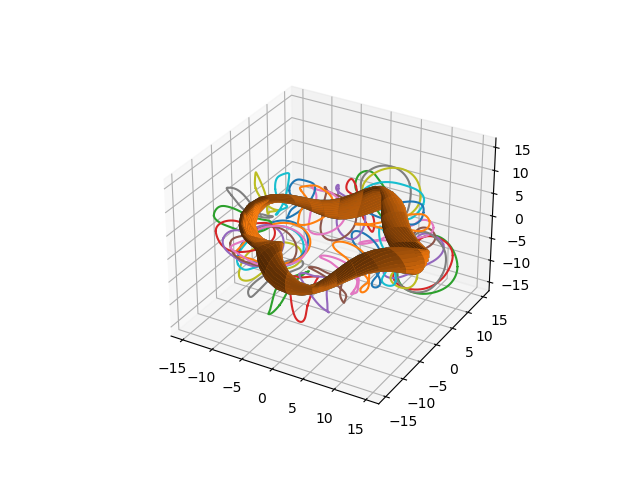

In [3]:
surf.plot(show=False, close=True)
ax=plt.gca()
surf.plot(ax=ax, show=False, close=True)
for c in bs.coils:
    c.curve.plot(ax=ax, show=False)

Text(0.5, 0, '$\\theta$')

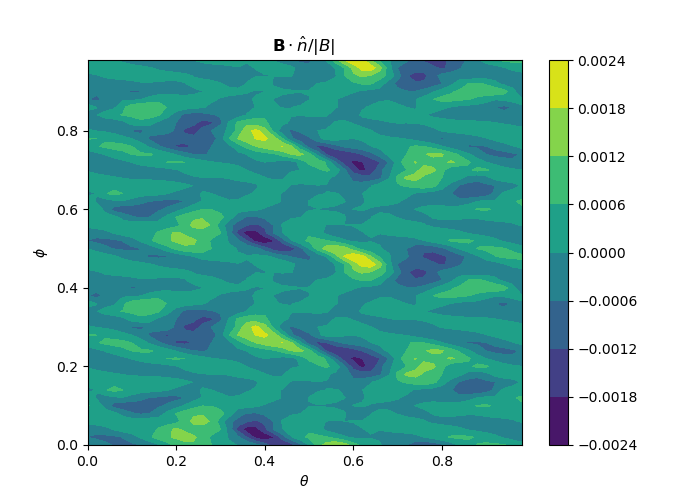

In [4]:
# We double-check that the coils correspond indeed to the plasma boundary.

surf = v.boundary
theta = surf.quadpoints_theta
phi = surf.quadpoints_phi
ntheta = theta.size
nphi = phi.size
bs.set_points(surf.gamma().reshape((-1,3)))
Bdotn = np.sum(bs.B().reshape((nphi, ntheta, 3)) * surf.unitnormal(), axis=2)
modB = bs.AbsB().reshape((nphi,ntheta))

fig, ax = plt.subplots(figsize=(7,5))
c = ax.contourf(theta,phi,Bdotn / modB)
plt.colorbar(c)
ax.set_title(r'$\mathbf{B}\cdot\hat{n} / |B|$ ')
ax.set_ylabel(r'$\phi$')
ax.set_xlabel(r'$\theta$')

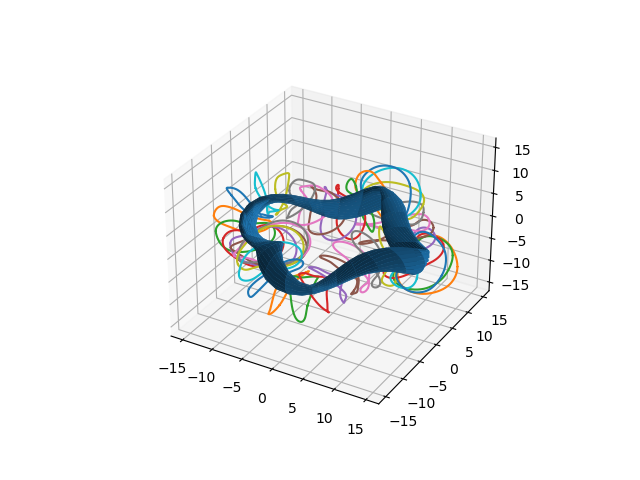

In [5]:
# Need to order coils in increasing toroidal angle. I did this one coil after another... Surely it could be automated!
curve = [
    bs.coils[0].curve,
    bs.coils[1].curve,
    bs.coils[2].curve,
    bs.coils[3].curve,
    bs.coils[4].curve,
    bs.coils[-1].curve,
    bs.coils[-2].curve,
    bs.coils[-3].curve,
    bs.coils[-4].curve,
    bs.coils[-5].curve,
    bs.coils[10].curve,
    bs.coils[11].curve,
    bs.coils[12].curve,
    bs.coils[13].curve,
    bs.coils[14].curve,
    bs.coils[-11].curve,
    bs.coils[-12].curve,
    bs.coils[-13].curve,
    bs.coils[-14].curve,
    bs.coils[-15].curve,
    bs.coils[20].curve,
    bs.coils[21].curve,
    bs.coils[22].curve,
    bs.coils[23].curve,
    bs.coils[24].curve,
    bs.coils[-21].curve,
    bs.coils[-22].curve,
    bs.coils[-23].curve,
    bs.coils[-24].curve,
    bs.coils[-25].curve,
    bs.coils[30].curve,
    bs.coils[31].curve,
    bs.coils[32].curve,
    bs.coils[33].curve,
    bs.coils[34].curve,
    bs.coils[-31].curve,
    bs.coils[-32].curve,
    bs.coils[-33].curve,
    bs.coils[-34].curve,
    bs.coils[-35].curve
]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
v.boundary.plot(ax=ax,show=False,close=True)
for c in curve:
    c.plot(ax=ax, show=False)

In [6]:
gamma_curves = []
for c in curve:
    gamma = c.gamma()
    d = gamma[0,2] - gamma[1,2]
    if d<0: # Need to flip coil direction such that they are all oriented in the same theta direction
        gamma = np.flip(gamma, axis=0)

    gamma_curves.append(gamma)
gamma_curves = np.array(gamma_curves)

# The number of toroidal and poloidal points have to match the number of coils and quadrature points.
nphi, ntheta, _ = gamma_curves.shape
qpts_theta = np.linspace(0,1,ntheta,endpoint=False)
qpts_phi = np.linspace(0,1,nphi,endpoint=False)

# We keep a low resolution to avoid over-fitting
winding_surface = SurfaceXYZTensorFourier( surf.nfp, surf.stellsym, mpol=6, ntor=4, quadpoints_phi=qpts_phi, quadpoints_theta=qpts_theta )

In [7]:
winding_surface.least_squares_fit( gamma_curves )

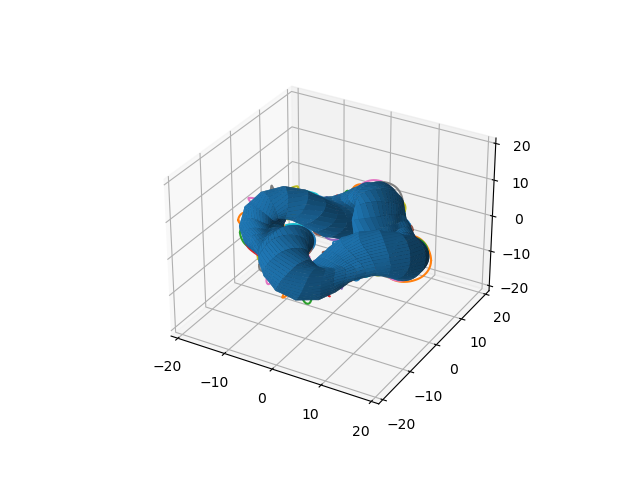

In [8]:
winding_surface.plot(show=False, close=True)
ax=plt.gca()
for c in bs.coils:
    c.curve.plot(ax=ax, show=False)

In [19]:
# Increasing the number of points for a better plot
qp_phi = np.linspace(0,1/(2*winding_surface.nfp),32)
qp_theta = np.linspace(0,1,64)
surf = SurfaceXYZTensorFourier( 
    nfp=winding_surface.nfp, 
    stellsym=winding_surface.stellsym, 
    mpol=winding_surface.mpol,
    ntor=winding_surface.ntor,
    quadpoints_phi=qp_phi,
    quadpoints_theta=qp_theta,
    dofs=winding_surface.dofs
)

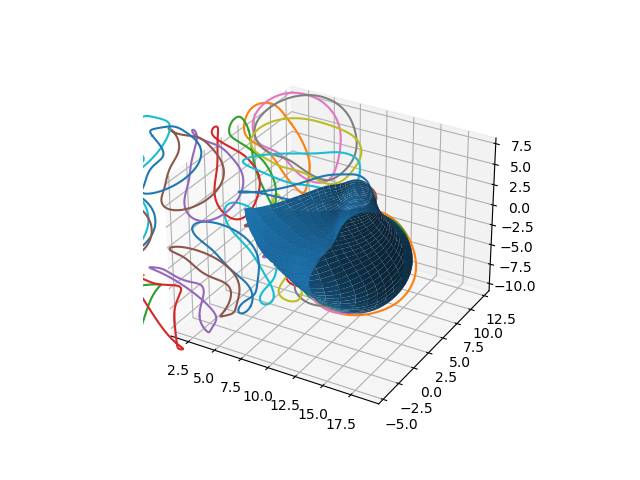

In [20]:
surf.plot(show=False, close=True)
ax=plt.gca()
for c in bs.coils:
    c.curve.plot(ax=ax, show=False)

## Test the winding surface class. 

As the coils are _almost_ on the surface, the winding surface penalty should be zero for a reasonable threshold value

In [21]:
# First we find the shortest distance from the coils to the surface
base_curves = [c.curve for c in bs.coils[0:5]]
Jcsdist = CurveSurfaceDistance( base_curves, surf, 0.5 )
sd = Jcsdist.shortest_distance()
print(sd)

0.00842212235441938


In [22]:
Jwsurf = WindingSurface( base_curves, surf, sd )

In [23]:
Jwsurf.J()

Array(0.02565752, dtype=float64)

In [30]:
Jwsurf = WindingSurface( base_curves, surf, sd*2 )
Jwsurf.J()

Array(0.01612845, dtype=float64)

### Taylor test

In [31]:
import copy
import numpy as np

dofs = copy.deepcopy(Jwsurf.x)
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0 = Jwsurf.J()
dJ0 = Jwsurf.dJ()
dJh = sum(dJ0 * h)
err = []
myeps = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
for eps in myeps:
    Jwsurf.x = dofs + eps*h
    J1 = Jwsurf.J()
    Jwsurf.x = dofs - eps*h
    J2 = Jwsurf.J()
    err.append((J1-J2)/(2*eps) - dJh)
    print("err", (J1-J2)/(2*eps) - dJh)

err -0.006293128273450119
err -8.681185367231947e-05
err -8.70909745015469e-07
err -8.709537951956392e-09
err -5.517600265569911e-11
err 3.156017114314125e-11
err 1.182963449419816e-10


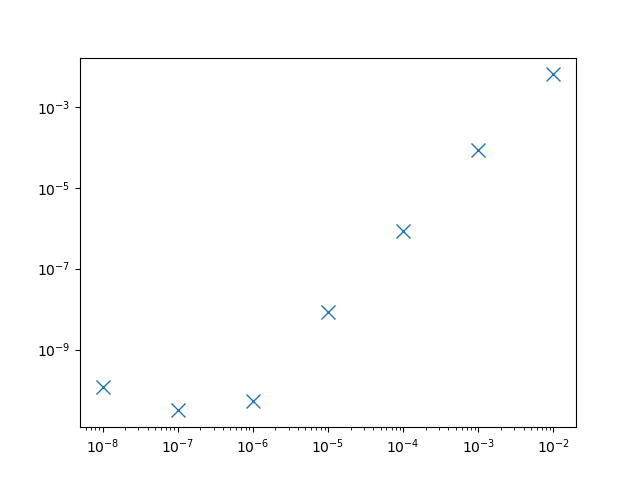

In [32]:
plt.figure()
plt.loglog( myeps, np.abs(err), 'x', markersize=10 )

In [17]:
surf.save('wiedman_winding_surface.json');